<a href="https://colab.research.google.com/github/YildirimSelahattin/brain-seg/blob/master/GMWM_Prediction_and_Visualization_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/catalyst-team/neuro/blob/master/examples/GMWM_Prediction_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain tissue segmentation and An (almost) instant brain atlas segmentation**

In this notebook we demonstrate how to perform inference with pretrained MeshNet and UNet models.  **MeshNet** can be up to **9x faster** and **>300x smaller** while maintaining comparable performance to UNet.

## Gray Matter White Matter Segmentation

The models were pretrained with 20 Volumes from the Human Connectome Project and validated on 4 held out volumes with 512 sampled subvolumes. With 5 more volumes of training the smallest MeshNet still outperforms UNet on the task as reported in the [paper](https://arxiv.org/pdf/1612.00940.pdf).

## Almost Instant Brain Atlas Segmentation
We also demonstrate inference using the pretrained large MeshNet model mentioned in the [paper](https://arxiv.org/pdf/1711.00457.pdf). 

## Model Performance

| Model      | Macro DICE |  Inference Speed | Model Size | Classes
| -----------| ----------- |----------- |----------- |----------- |
| MeshNet     | .9565 | 116 subvolumes/sec | .89 mb | 3
| MeshNet Dropout  | .8748 | 115 subvolumes/sec | .89 mb | 3
| MeshNet Large  | .9652 | 19 subvolumes/sec | 9mb | 3
| MeshNet Large Dropout  | .9354 | 19 subvolumes/sec | 9mb | 3
| MeshNet Large | ~.85 | 18 subvolumes/sec |  10 mb | 104
| UNet  | .9624  | 13 subvolumes/sec |  288 mb | 3

---


Authors: [Kevin Wang](https://github.com/ssktotoro/), [Alex Fedorov](https://github.com/Entodi/), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

## Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `\"Python 3\"` and `\"GPU\"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.

## Setup Environment

In [ ]:
%%bash 
git clone https://github.com/catalyst-team/neuro.git
pip install -r neuro/requirements/requirements.txt

  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=8082d68e85609fc8d107e50ad8c1509e68655a4f1d9ff6ba0a69c2550cf7251e
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Cloning into 'neuro'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Setup imports

In [ ]:
import torch
import nibabel as nib
from catalyst.metrics.functional._segmentation import dice
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
cd neuro

/content/neuro


In [ ]:
from neuro.predictor import Predictor
from neuro.model import MeshNet, UNet

## Download models

In [ ]:
%%bash 

download-gdrive 1o15GWOXFWeY0hYPtlD4136ecNTP3uT8B meshnet_gmwm_large_train.30_full.pth
download-gdrive 1XCbM57loIUs_tVJeMZaGazG_Id4jPZMy meshnet_gmwm_train.30_full.pth
download-gdrive 13dJY9i5xCd3IEBvOg9QsFCEhBbhvvJHZ unet_gmwm_train.30_full.pth
download-gdrive 1t0OiTL3cnzV4PdbL1LZm2JCz1kZNABB4 meshnet_hcp_train.30_full.pth

download-gdrive 1EBRKOwFXFNvInaCgCtdhNy9ZC0-8DO4L meshnet_gmwm_large_dropout_train.30_full.pth
download-gdrive 1hiDHb7Qr91QQVKTionQoZr9JUuzWHjGO meshnet_gmwm_dropout_train.30_full.pth

--2021-12-03 11:50:18--  https://docs.google.com/uc?export=download&confirm=&id=1o15GWOXFWeY0hYPtlD4136ecNTP3uT8B
Resolving docs.google.com (docs.google.com)... 74.125.23.113, 74.125.23.102, 74.125.23.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.23.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-b0-docs.googleusercontent.com/docs/securesc/dmocu9md00higk4i8daj8o2fbcr959de/vov0mtum12cgfukigr4j76qjloq2c3ie/1638532200000/01187487326786428538/03169839192196581829Z/1o15GWOXFWeY0hYPtlD4136ecNTP3uT8B?e=download [following]
--2021-12-03 11:50:19--  https://doc-08-b0-docs.googleusercontent.com/docs/securesc/dmocu9md00higk4i8daj8o2fbcr959de/vov0mtum12cgfukigr4j76qjloq2c3ie/1638532200000/01187487326786428538/03169839192196581829Z/1o15GWOXFWeY0hYPtlD4136ecNTP3uT8B?e=download
Resolving doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc

### Prepare Models for inference and download a sample T1 scan

Because our models classify subvolumes we adopt a majority voting method that ensures every voxel is classified and focuses on important voxels.  First we classify all non-overlapping 38x38x38 subvolumes in a regular grid partitioning the volume space. This ensure a prediction for every voxel.  Next we randomly sample overlapping subvolumes from a gaussian distribution in the center of the brain like in training until the required number of subvolumes is reached.  For every voxel the class with the majority vote is the prediction.  Here we use 1024 subvolumes for demonstration though more subvolumes can increase the DICE score.

In [ ]:
volume_shape = [256, 256, 256]
subvolume_shape = [38, 38, 38]
n_subvolumes = 1024
n_classes = 3
atlas_classes = 104
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
meshnet_large_model = MeshNet(n_channels=1, n_classes=n_classes, large=True)
meshnet_large_model.load_state_dict(torch.load('meshnet_gmwm_large_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_large_model.to(device)
meshnet_large_predictor = Predictor(meshnet_large_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_dropout_model = MeshNet(n_channels=1, n_classes=n_classes, large=False)
meshnet_dropout_model.load_state_dict(torch.load('meshnet_gmwm_dropout_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_dropout_model.to(device)
meshnet_dropout_predictor = Predictor(meshnet_dropout_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_large_dropout_model = MeshNet(n_channels=1, n_classes=n_classes, large=True)
meshnet_large_dropout_model.load_state_dict(torch.load('meshnet_gmwm_large_dropout_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_large_dropout_model.to(device)
meshnet_large_dropout_predictor = Predictor(meshnet_large_dropout_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_model = MeshNet(n_channels=1, n_classes=n_classes, large=False)
meshnet_model.load_state_dict(torch.load('meshnet_gmwm_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_model.to(device)
meshnet_predictor = Predictor(meshnet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

meshnet_atlas_model = MeshNet(n_channels=1, n_classes=atlas_classes, large=True)
meshnet_atlas_model.load_state_dict(torch.load('meshnet_hcp_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_atlas_model.to(device)
meshnet_atlas_predictor = Predictor(meshnet_atlas_model, volume_shape, subvolume_shape, n_subvolumes, atlas_classes)

unet_model = UNet(n_channels=1, n_classes=n_classes)
unet_model.load_state_dict(torch.load('unet_gmwm_train.30_full.pth', map_location=device)['model_state_dict'])
unet_model.to(device)
unet_predictor = Predictor(unet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

In [ ]:
! wget -nc https://dl.dropbox.com/s/g1vn5p3grifro4d/T1w.nii.gz

--2021-12-03 11:51:01--  https://dl.dropbox.com/s/g1vn5p3grifro4d/T1w.nii.gz
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/g1vn5p3grifro4d/T1w.nii.gz [following]
--2021-12-03 11:51:01--  https://dl.dropboxusercontent.com/s/g1vn5p3grifro4d/T1w.nii.gz
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22872802 (22M) [application/octet-stream]
Saving to: ‘T1w.nii.gz’

T1w.nii.gz          100%[===================>]  21.81M  9.06MB/s    in 2.4s    

2021-12-03 11:51:05 (9.06 MB/s) - ‘T1w.nii.gz’ saved [22872802/22872802]



In [ ]:
img = nib.load('T1w.nii.gz')
img = img.get_fdata()

## Segment Sample Brains with timing

In [ ]:
%time meshnet_large_predicted_segmentation = meshnet_large_predictor.predict('T1w.nii.gz')

CPU times: user 2min 53s, sys: 220 ms, total: 2min 53s
Wall time: 2min 53s


In [ ]:
%time meshnet_predicted_segmentation = meshnet_predictor.predict('T1w.nii.gz')

CPU times: user 21.6 s, sys: 131 ms, total: 21.7 s
Wall time: 21.6 s


In [ ]:
%time meshnet_large_dropout_predicted_segmentation = meshnet_large_dropout_predictor.predict('T1w.nii.gz')

CPU times: user 2min 53s, sys: 215 ms, total: 2min 53s
Wall time: 2min 52s


In [ ]:
%time meshnet_dropout_predicted_segmentation = meshnet_dropout_predictor.predict('T1w.nii.gz')

CPU times: user 21.5 s, sys: 107 ms, total: 21.6 s
Wall time: 21.4 s


In [ ]:
%time meshnet_atlas_predicted_segmentation = meshnet_atlas_predictor.predict('T1w.nii.gz')

CPU times: user 2min 59s, sys: 1.09 s, total: 3min
Wall time: 3min


In [ ]:
%time unet_predicted_segmentation = unet_predictor.predict('T1w.nii.gz')

/content/neuro/neuro/model.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  diffX // 2,


CPU times: user 2min 51s, sys: 290 ms, total: 2min 51s
Wall time: 2min 50s


## Visualize Predictions

In [ ]:
def show_slices(slices, raw=True):
    if raw:
        cmap = 'jet'
    else:
        cmap = 'nipy_spectral'
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='nipy_spectral')

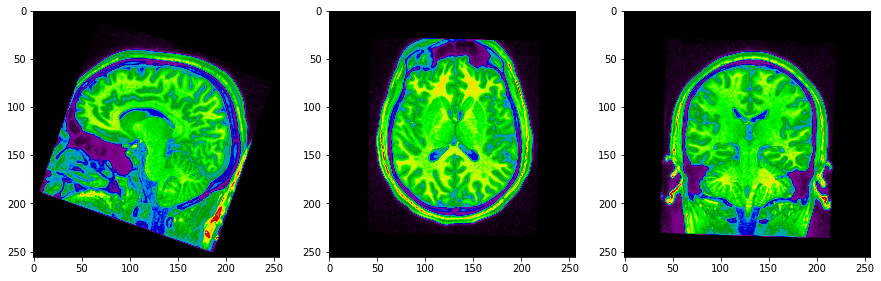

In [ ]:
show_slices(
    [img[120, :,:][:, ::-1], 
     img[:, 120,:].T[::-1], 
     img[:, :, 120].T])

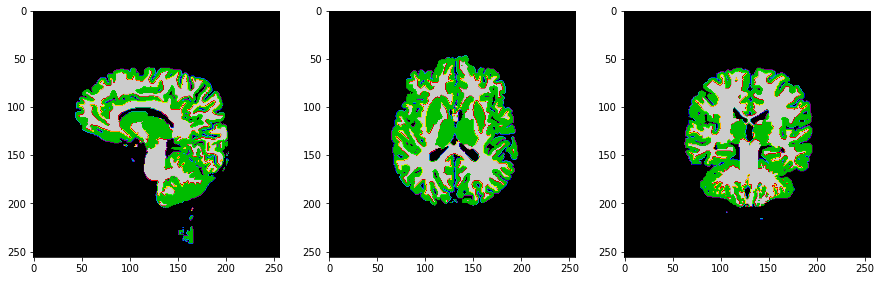

In [ ]:
show_slices(
    [meshnet_large_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_large_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_large_predicted_segmentation[:, :, 120].cpu().T], raw=False)

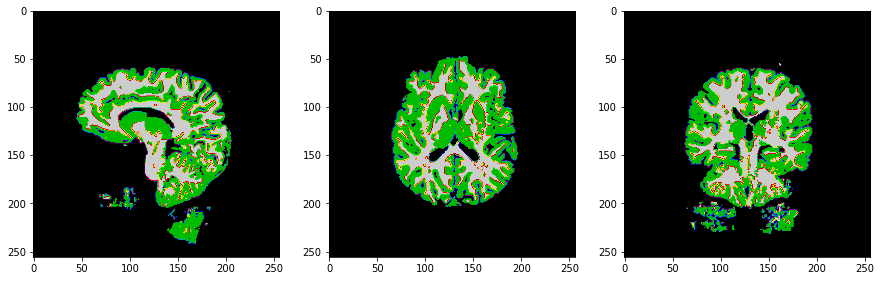

In [ ]:
show_slices(
    [meshnet_large_dropout_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_large_dropout_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_large_dropout_predicted_segmentation[:, :, 120].cpu().T], raw=False)

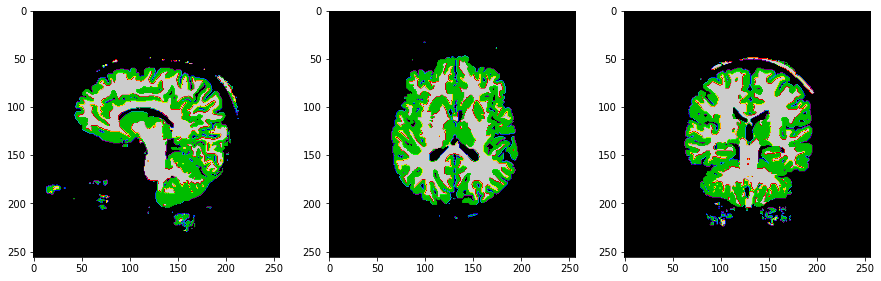

In [ ]:
show_slices(
    [meshnet_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_predicted_segmentation[:, :, 120].cpu().T], raw=False)

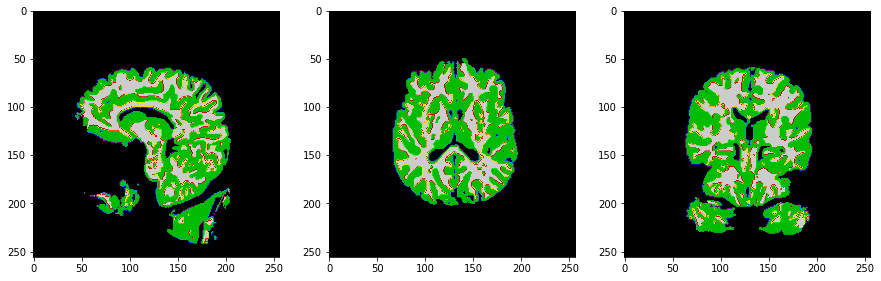

In [ ]:
show_slices(
    [meshnet_dropout_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_dropout_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_dropout_predicted_segmentation[:, :, 120].cpu().T], raw=False)

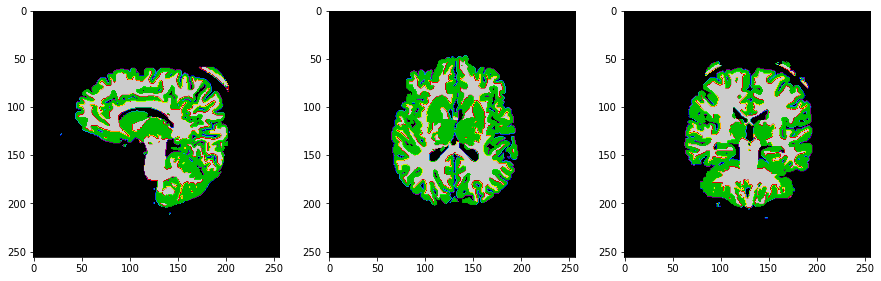

In [ ]:
show_slices(
    [unet_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     unet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     unet_predicted_segmentation[:, :, 120].cpu().T], raw=False)

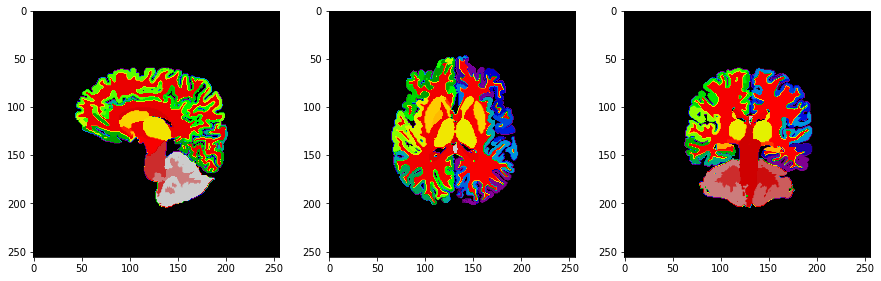

In [ ]:
show_slices(
    [meshnet_atlas_predicted_segmentation[120, :,:].cpu().numpy()[:, ::-1], 
     meshnet_atlas_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_atlas_predicted_segmentation[:, :, 120].cpu().T], raw=False)

## Comparing Visualizations

Meshnet with Dropout obtains a lower DICE score due to incorrectly segmenting the skull and the neck areas.  However, it looks like the ventricles and some other structures improve.  The neck can easily be removed via postprocessing so in practice the lower DICE score would not a problem.  